In [41]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
from skimage.feature import hog
import glob

In [42]:
def split_image(image):
    Y,X = image.shape[0], image.shape[1]
    img = image[int(Y/2):,:,:]
    return img

def bin_spatial(image, resize= (32,32)):
    return cv2.resize(image, resize).ravel()

def hist_feature(img, nbins=32, bins_range= (0, 256)):
    channel_1 = np.histogram(img[:,:,0], bins = nbins, range = bins_range)
    channel_2 = np.histogram(img[:,:,1], bins = nbins, range = bins_range)
    channel_3 = np.histogram(img[:,:,2], bins = nbins, range = bins_range)
    hist_features = np.concatenate((channel_1[0],channel_2[0],channel_3[0]))
    return hist_features
    
def extract_color_feature(image, nbins=32, bins_range=(0, 256), resize = (32,32)):
    img = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    bin_feature = bin_spatial(img, resize)
    hist_features = hist_feature(img, nbins, bins_range)
    return bin_feature,hist_features

# fig, axs = plt.subplots(8,8, figsize=(16, 16))
# fig.subplots_adjust(hspace = .2, wspace=.001)
# axs = axs.ravel()
j = 0
#     show_image(test_image)
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    features_list = []
    global j
#     images = []
    
#         print("i"+str(i))
    if vis == True:
        feature, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                    cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                    visualise=vis, feature_vector=feature_vec)
#             features_list.append(feature)
#             j= j + 1
#             if(j == 1):
#             show_image(img)
#             show_image(hog_image)
    else:      
        feature = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                        cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                        visualise=vis, feature_vector=feature_vec)
#             features_list.append(feature)
#     features = np.concatenate(features_list)
    return feature

In [43]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

#(256-(128*0.5))/(128 * (1-0.5))
def sliding_window(clf, scalar, image, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64,64), xy_overlap=(0.5,0.5), scale = 1.0):
#     nx = x_start_stop[1] - x_start_stop[0]
#     ny = y_start_stop[1] - y_start_stop[0]
    rectangles = []
    img = image.astype(np.float32)/255
    img_tosearch = img[y_start_stop[0]:y_start_stop[1],:,:]
    img_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    ctrans_tosearch = cv2.resize(img_tosearch,(np.int(img_tosearch.shape[1]/scale),np.int(img_tosearch.shape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    orient= 9
    pix_per_cell = 8
    cell_per_block = 2
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    window = 64
    
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cells_per_step, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cells_per_step, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cells_per_step, feature_vec=False)
    features=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
#             print(hog1.shape)
#             show_image(hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window])
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
#             features.append(hog_feat1)
#             features.append(hog_feat2)
#             features.append(hog_feat3)
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3)).reshape(1,-1)
#             hog_features = np.ravel(hog_features)
#             features = np.concatenate(hog_features)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32,32))
          
#             # Get color features
#             spatial_features = bin_spatial(subimg, resize=(32,32))
#             hist_features = hist_feature(subimg, nbins=32)

#             # Scale features and make a prediction
            test_features = scalar.transform(hog_features)#.reshape(1, -1)   
#             #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = clf.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0])))
#                 cv2.rectangle(image,(xbox_left, ytop_draw+y_start_stop[0]),(xbox_left+win_draw,ytop_draw+win_draw+y_start_stop[0]),(0,0,255),6) 
                
    return rectangles

#     x_step = np.int(xy_window[1] * (1 - xy_overlap[1]))
#     y_step = np.int(xy_window[0] * (1 - xy_overlap[0]))
    
#     fig, axs = plt.subplots(8,8, figsize=(16, 16))
#     fig.subplots_adjust(hspace = .2, wspace=.001)
#     axs = axs.ravel()
#     window_nx = np.int((np.int(nx - (xy_window[1] * xy_overlap[1]))) / x_step)
#     window_ny = np.int((np.int(ny - (xy_window[0] * xy_overlap[0]))) / y_step)
#     windows = []
#     i = 0
#     for y_window in range(window_ny):
#         for x_window in range(window_nx):
#             xstart = x_window * x_step + x_start_stop[0]
#             xend = xstart +  xy_window[0]
#             ystart = y_window * y_step + y_start_stop[0]
#             yend = ystart + xy_window[1]
            
#             test_image = cv2.resize(image[ystart:yend, xstart:xend],(64,64))
# #             show_image(test_image)
#             axs[i].imshow(test_image) 
#             i= i + 1
#             feature = feature_extractor(test_image).astype(np.float64)
#             X = scalar.transform(np.array(feature).reshape(1, -1))
#             predict = clf.predict(X)
#             print(predict)
#             windows.append(((xstart,ystart),(xend,yend)))
#     return windows
            

In [44]:
def show_image(img):
    plt.imshow(img)
#     plt.plot(img)

def feature_extractor(image):
    features = []
    bin_feature, hist_features = extract_color_feature(image)
#     features.append(bin_feature)
#     features.append(hist_features)
    hog_features = []
    img = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    for i in range(image.shape[2]):
        hog_feat = get_hog_features(img[:,:,i], 9, 8, 2, vis=True, feature_vec=True)
        hog_features.append(hog_feat)
    hog_features = np.ravel(hog_features)
#     print(hog_features.shape)
    features.append(hog_features)
    features = np.concatenate(features)
    return features
# image = mpimg.imread('/Users/swapnilsoni/Downloads/vehicles_smallset/cars1/1.jpeg')
# img = split_image(image)
# X = feature_extractor(image)
# print(X.shape)
# bb_boxes = sliding_window(image, x_start_stop=[0, image.shape[1]], y_start_stop=[int(image.shape[0]/2), image.shape[0]])
# print(bb_boxes)
# image = draw_boxes(image, bb_boxes)
# print(bb_boxes)
# show_image(image)

In [45]:
images_cars = glob.glob('./vehicles/*/*.png')#glob.glob('./vehicles/*/*.png')
images_non_cars = glob.glob('./non-vehicles/*/*.png')#glob.glob('./non-vehicles/*/*.png')
cars = []
non_cars = []

for image_path in images_cars:
    image = mpimg.imread(image_path)
    cars.append(image)
for image_path in images_non_cars:
    image = mpimg.imread(image_path)
    non_cars.append(image)

features_car = []
features_non_car = []

for image in cars:
    features_car.append(feature_extractor(image))

for image in non_cars:
    features_non_car.append(feature_extractor(image))

X = np.vstack((features_car, features_non_car)).astype(np.float64)                        
y = np.hstack((np.ones(len(features_car)), np.zeros(len(features_non_car))))
# print(X.shape)

X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)

rand_state = np.random.randint(0, 100)

X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

svc = LinearSVC()

svc.fit(X_train, y_train)

predict = svc.predict(X_test)

acc = accuracy_score(y_test, predict)
matrx = confusion_matrix(y_test, predict)
print(acc)

print(matrx)

with open('clf.pkl', 'wb') as f:
    pickle.dump(svc, f)
with open('X_scaler.pkl', 'wb') as f:
    pickle.dump(X_scaler, f)

0.9822635135135135
[[1783   31]
 [  32 1706]]


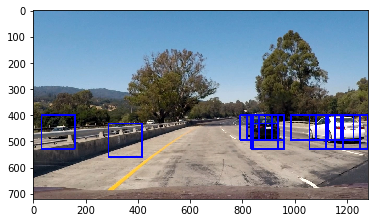

In [56]:
from scipy.ndimage.measurements import label

def draw_heat_map(heat_map, bboxes):
    for box in bboxes:
        heat_map[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heat_map

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final rectangles
    return img, rects
bb_boxes = []
clf = pickle.load(open('clf.pkl', 'rb'))
scalar = pickle.load(open('X_scaler.pkl', 'rb'))
def predict_cars(img):
    global bb_boxes
#     image_test = glob.glob('./test_images/test3.jpg')
#     img = cv2.imread(image_test[0])
    rects = []
    ystart = 400
    ystop = 464
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop], scale=1.0))
    ystart = 416
    ystop = 480
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop],scale=1.0))
    ystart = 400
    ystop = 496
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop],scale=1.5))
    ystart = 432
    ystop = 528
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop],scale=1.5))
    ystart = 400
    ystop = 528
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop],scale=2.0))
    ystart = 432
    ystop = 560
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop],scale=2.0))
    ystart = 400
    ystop = 596
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop],scale=3.5))
    ystart = 464
    ystop = 660
    rects.append(sliding_window(clf, scalar, img, x_start_stop=[0, img.shape[1]], y_start_stop=[ystart, ystop],scale=3.5))
       
        
    bb_boxes = [item for items in rects for item in items]
    image = draw_boxes(img, bb_boxes)
    heat_map = np.zeros_like(image[:,:,1])
    heat_map = draw_heat_map(heat_map, bb_boxes)
    heat_map = apply_threshold(heat_map, 1)
    labels = label(heat_map)
    img_new, rects = draw_labeled_bboxes(img, labels)
    return img_new
#     show_image(image)
#     print(labels[1])
    

#     show_image(image)
# image_test = glob.glob('./test_images/test1.jpg')
# img = mpimg.imread(image_test[0])
# img.shape
# predict_cars(img)


    #extract image from video
    #split image
    #sliding and predicting
    #all predicted

In [53]:
from moviepy.editor import VideoFileClip
white_output = 'output_images/project_video.mp4'
clip3 = VideoFileClip('./project_video.mp4')
# clip = video.subclip(0,0)
white_clip = clip3.fl_image(predict_cars)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [08:01<00:00,  2.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 7min 44s, sys: 23.7 s, total: 8min 7s
Wall time: 8min 2s
